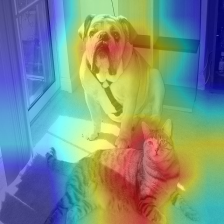

In [34]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

import requests
import torchvision
from PIL import Image
import numpy as np

image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
image=image[:,:,[0,0,0]]
image_float_np = np.float32(image) / 255
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image)
input_tensor=input_tensor[None,:,:,:]

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
# input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)


# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget(281)]
targets=[ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)

In [38]:
ClassifierOutputTarget(2).category
input_tensor.shape
model
# image[:,:,0]
# image.shape

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [3]:
import pytest
import torchvision
import torch
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

torch.manual_seed(0)


@pytest.fixture
def numpy_image():
    return cv2.imread("examples/both.png")


@pytest.mark.parametrize("cam_method",
                         [GradCAM])
def test_memory_usage_in_loop(numpy_image, cam_method):
    model = torchvision.models.resnet18(pretrained=False)
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(
            7, 7), stride=(
            2, 2), padding=(
                3, 3), bias=False)
    target_layers = [model.layer4]
    gray_img = numpy_image[:, :, 0]
    input_tensor = torch.from_numpy(
        np.float32(gray_img)).unsqueeze(0).unsqueeze(0)
    input_tensor = input_tensor.repeat(16, 1, 1, 1)
    print("input_tensor", input_tensor.shape)
    targets = None
    with cam_method(model=model,
                    target_layers=target_layers,
                    use_cuda=False) as cam:
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets)
        print(grayscale_cam.shape)